In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

In [56]:
df = pd.read_csv('wildfire_data_preprocessed.csv')
print(f"Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

Data loaded: 9,509,925 rows × 22 columns


In [57]:
print(f"Total records: {df.shape[0]:,}")
print(f"Wildfire days: {df['Wildfire_binary'].sum():,}")
print(f"Non-wildfire days: {(df['Wildfire_binary'] == 0).sum():,}")
print(f"Wildfire rate: {df['Wildfire_binary'].mean():.3%}")

Total records: 9,509,925
Wildfire days: 502,065
Non-wildfire days: 9,007,860
Wildfire rate: 5.279%


In [58]:
display(df.head())

,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,...,bi,fm100,fm1000,erc,etr,pet,vpd,Wildfire_binary,window_id,days_from_ignition
0,48.128431,-97.276685,2018-08-15,No,-0.053101,-0.050631,-0.063031,-0.052081,-0.021598,-0.051093,...,-0.048324,-0.053601,-0.053433,-0.045941,-0.050984,-0.051275,-0.051811,0,0,-60
1,48.128431,-97.276685,2018-08-16,No,-0.053101,-0.049571,-0.063620,-0.052080,-0.026678,-0.049967,...,-0.048324,-0.053895,-0.053551,-0.044765,-0.050573,-0.051040,-0.051612,0,0,-59
2,48.128431,-97.276685,2018-08-17,No,-0.053101,-0.055165,-0.059797,-0.052080,-0.025733,-0.048841,...,-0.048324,-0.054189,-0.053609,-0.044765,-0.051161,-0.051393,-0.051858,0,0,-58
3,48.128431,-97.276685,2018-08-18,No,-0.050163,-0.058522,-0.060385,-0.052080,-0.028214,-0.046945,...,-0.071849,-0.053777,-0.053551,-0.054178,-0.049515,-0.050453,-0.051659,0,0,-57
4,48.128431,-97.276685,2018-08-19,No,-0.053101,-0.038028,-0.046975,-0.052079,-0.084101,-0.050027,...,-0.047736,-0.052661,-0.053492,-0.050059,-0.052688,-0.052509,-0.052358,0,0,-56


In [59]:
#Days in which fire occurred
fire_days = df[df['Wildfire_binary'] == 1]
print(f"Fire days: {len(fire_days):,}")

Fire days: 502,065


In [60]:
#creating a size for clustering
sample_size = min(50000, len(fire_days))
fire_sample = fire_days.sample(n=sample_size, random_state=42)
print(f"Using sample of {sample_size:,} fire days for clustering")

Using sample of 50,000 fire days for clustering


In [61]:
#preparing features for clustering
normalization_cols = ['pr', 'rmax', 'rmin', 'sph', 'srad', 'tmmn', 'tmmx', 'vs', 
                     'bi', 'fm100', 'fm1000', 'erc', 'etr', 'pet', 'vpd']

cluster_features = ['latitude', 'longitude'] + normalization_cols
X_cluster = fire_sample[cluster_features]

print(f"Clustering matrix shape: {X_cluster.shape}")
print(f"Features used: {len(cluster_features)}")
print("Feature list:")
for i, feature in enumerate(cluster_features, 1):
    print(f"  {i:2d}. {feature}")

Clustering matrix shape: (50000, 17)
Features used: 17
Feature list:
   1. latitude
   2. longitude
   3. pr
   4. rmax
   5. rmin
   6. sph
   7. srad
   8. tmmn
   9. tmmx
  10. vs
  11. bi
  12. fm100
  13. fm1000
  14. erc
  15. etr
  16. pet
  17. vpd


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


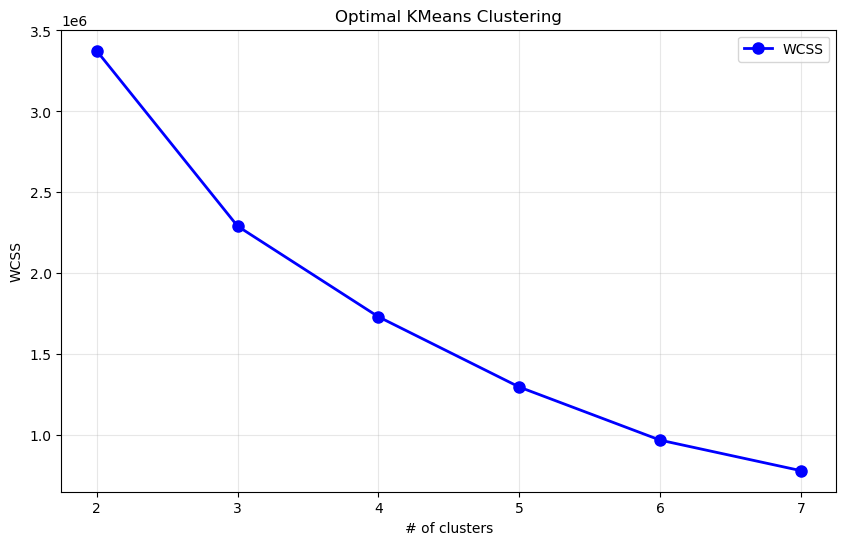

WCSS values:
  K=2: 3,374,781
  K=3: 2,291,770
  K=4: 1,731,720
  K=5: 1,297,860
  K=6: 969,960
  K=7: 781,299


In [62]:
#K Means Clustering - Finding Optimal Clustering
k_range = range(2, 8)
wcss = []  # Within-cluster sum of squares

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8, label='WCSS')
plt.xlabel('# of clusters')
plt.ylabel('WCSS')
plt.title('Optimal KMeans Clustering')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("WCSS values:")
for k, w in zip(k_range, wcss):
    print(f"  K={k}: {w:,.0f}")

In [63]:
#KMeans Clustering with Optimal
optimal_k = 6  # Adjust based on elbow plot above

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
fire_sample = fire_sample.copy()
fire_sample['fire_cluster'] = kmeans.fit_predict(X_cluster)

print("Cluster distribution:")
cluster_counts = fire_sample['fire_cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(fire_sample)) * 100
    print(f"  Cluster {cluster}: {count:,} fires ({percentage:.1f}%)")

fig = plt.figure(figsize=(20, 16))

Cluster distribution:
  Cluster 0: 9,590 fires (19.2%)
  Cluster 1: 4,966 fires (9.9%)
  Cluster 2: 17,430 fires (34.9%)
  Cluster 3: 6,011 fires (12.0%)
  Cluster 4: 4,105 fires (8.2%)
  Cluster 5: 7,898 fires (15.8%)


<Figure size 2000x1600 with 0 Axes>

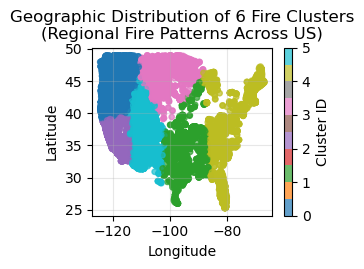

In [64]:
#Geographic distribution of fire clusters
plt.subplot(2, 2, 1)
scatter = plt.scatter(fire_sample['longitude'], fire_sample['latitude'], 
                     c=fire_sample['fire_cluster'], cmap='tab10', alpha=0.7, s=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of 6 Fire Clusters\n(Regional Fire Patterns Across US)')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)

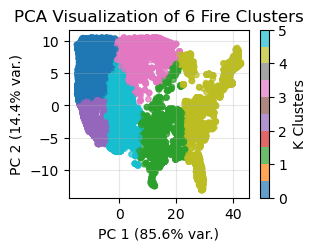

In [65]:
#PCA Visualization
plt.subplot(2, 2, 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fire_sample['fire_cluster'], 
           cmap='tab10', alpha=0.7, s=15)
plt.xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]:.1%} var.)')
plt.ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]:.1%} var.)')
plt.title(f'PCA Visualization of 6 Fire Clusters')
plt.colorbar(label='K Clusters')
plt.grid(True, alpha=0.3)

In [66]:
# Feature contributions to principal components
pca_components_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=cluster_features
)

print("Feature contributions to principal components:")
display(pca_components_df.sort_values('PC1', key=abs, ascending=False).head(10))

Feature contributions to principal components:


,PC1,PC2
longitude,0.999993,0.003612
latitude,-0.003612,0.999993
srad,-0.000728,0.000176
erc,-0.000428,-0.000399
bi,-0.000299,-0.000354
rmax,0.000260,0.000321
rmin,0.000195,0.000166
fm1000,0.000089,0.000068
tmmx,-0.000086,-0.000216
fm100,0.000070,0.000043


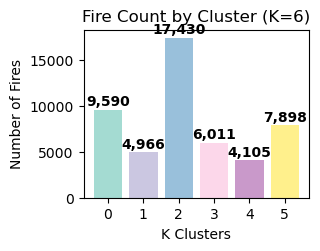

In [67]:
#Cluster Sizes
plt.subplot(2, 2, 3)
colors = plt.cm.Set3(np.linspace(0, 1, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.8)
plt.xlabel('K Clusters')
plt.ylabel('Number of Fires')
plt.title('Fire Count by Cluster (K=6)')
plt.xticks(range(6))
for bar, count in zip(bars, cluster_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

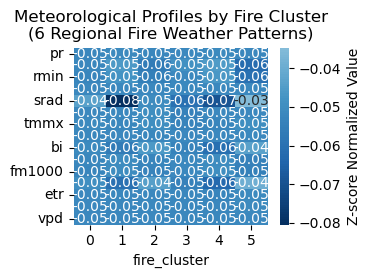

In [68]:
#Meteorological Profiles Heatmap
plt.subplot(2, 2, 4)
cluster_profile = fire_sample.groupby('fire_cluster')[normalization_cols].mean()
sns.heatmap(cluster_profile.T, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            cbar_kws={'label': 'Z-score Normalized Value'})
plt.title('Meteorological Profiles by Fire Cluster\n(6 Regional Fire Weather Patterns)')

plt.tight_layout()
plt.show()

In [69]:
#Analyzing the 6 regional fire patterns

In [70]:
#By Geographically means
cluster_centers_geo = fire_sample.groupby('fire_cluster')[['latitude', 'longitude']].mean()
print("\nApproximate Geographic Centers:")
for cluster, (lat, lon) in cluster_centers_geo.iterrows():
    print(f"   Cluster {cluster}: Lat {lat:.2f}°, Lon {lon:.2f}°")


Approximate Geographic Centers:
   Cluster 0: Lat 43.95°, Lon -119.53°
   Cluster 1: Lat 34.28°, Lon -94.36°
   Cluster 2: Lat 35.24°, Lon -118.49°
   Cluster 3: Lat 46.04°, Lon -101.39°
   Cluster 4: Lat 37.13°, Lon -79.48°
   Cluster 5: Lat 36.61°, Lon -109.68°


In [71]:
#Top differntiating weather variables
variable_importance = cluster_profile.T.abs().mean(axis=1).sort_values(ascending=False)
print(f"\nTop 5 Most Important Weather Factors:")
for i, (var, importance) in enumerate(variable_importance.head(5).items(), 1):
    print(f"   {i}. {var.upper():<8} (impact score: {importance:.3f})")


Top 5 Most Important Weather Factors:
   1. SRAD     (impact score: 0.057)
   2. RMIN     (impact score: 0.052)
   3. FM1000   (impact score: 0.052)
   4. FM100    (impact score: 0.052)
   5. PET      (impact score: 0.052)


In [72]:
#Create a folder for all cluster files
folder_name = 'wildfire_clusters'
os.makedirs(folder_name, exist_ok=True)

for cluster_num in range(optimal_k):
    #Get data for this cluster
    cluster_data = fire_sample[fire_sample['fire_cluster'] == cluster_num]
    
    #Create filename with cluster info
    fire_count = len(cluster_data)
    percentage = (fire_count / len(fire_sample)) * 100
    
    filename = f'{folder_name}/cluster_{cluster_num}_{fire_count}fires_{percentage:.1f}percent.csv'
    
    #Save the file
    cluster_data.to_csv(filename, index=False)

In [73]:
#Check correlation between PET and your key features
correlations = df[['pet', 'srad', 'rmin', 'fm100']].corr()
print(correlations)

            pet      srad      rmin     fm100
pet    1.000000  0.998706  0.999932  0.999992
srad   0.998706  1.000000  0.998312  0.998556
rmin   0.999932  0.998312  1.000000  0.999963
fm100  0.999992  0.998556  0.999963  1.000000
